# Leakage pattern prediction

This code simply generates images of a leakage pattern.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import leakagelib

>>> PyXSPEC is not installed, you will no be able to use it.


Leakage depends on energy and therefore the observed spectrum. Let's assume an unabsorbed spectrum with photon index 2, just for demonstration purposes.

In [2]:
SOURCE_SIZE = 53 # pixels
PIXEL_SIZE = 2.8 # arcsec
SPECTRUM = leakagelib.Spectrum.from_power_law_index(2)

>>> Reading (in memory) /opt/homebrew/anaconda3/lib/python3.12/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/arf/ixpe_d1_obssim20240101_v013.arf...


## Point source prediction

We first need to make an object describing where the source is. Let's do a point source first.

In [3]:
source = leakagelib.Source.delta(
    False,  # Use Moments data
    SOURCE_SIZE,  # Number of spatial bins to put in a single row of your image. The image is assumed to be square
    PIXEL_SIZE # The size of each pixel in arcsec. Together this and the previous argument multiply to give the width of the image in arcsec
)

We'll load a sample observation: GX 9+9, which has low polarization. You will have to download this data set from the IXPE archive. Put it in your standard data folder. If you have added that folder path to the `DATA_DIRECTORIES` variable in the `settings.py` file of the leakagelib source code, the following line of code should find the file.

In [4]:
ixpe_datas = leakagelib.IXPEData.load_all_detectors(source, "01002401", bin=True)

/opt/homebrew/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Successfully loaded files
	/Users/jtd/Documents/research/ixpepl/data/01002401/event_l2/ixpe01002401_det1_evt2_v01.fits
	/Users/jtd/Documents/research/ixpepl/data/01002401/event_l2/ixpe01002401_det2_evt2_v01.fits
	/Users/jtd/Documents/research/ixpepl/data/01002401/event_l2/ixpe01002401_det3_evt2_v01.fits


Let's take detector 1, center it so the point source is in the middle, and generate a PSF object

In [5]:
ixpe_data = ixpe_datas[0]
ixpe_data.iterative_centroid_center()

psf = leakagelib.PSF.sky_cal(
    1,                   # Use the given detector index
    source,              # Use the Source object just created
    ixpe_data.rotation   # Rotate the source by this amount
)

Now we'll compute some leakage patterns. The flux won't be right because we didn't tell the source how bright it is. We'll renormalize the I flux to be the same as the source's.

In [6]:
pred_i, pred_q, pred_u = source.compute_leakage(
    psf,                # Use the PSF that was just loaded
    ixpe_data.spectrum, # Use an example power-law spectrum
    normalize=False     # Compute the unnormalized coefficients
)
pred_q *= np.sum(ixpe_data.i) / np.sum(pred_i)
pred_u *= np.sum(ixpe_data.i) / np.sum(pred_i)
pred_i *= np.sum(ixpe_data.i) / np.sum(pred_i)

Now we display the patterns and residuals

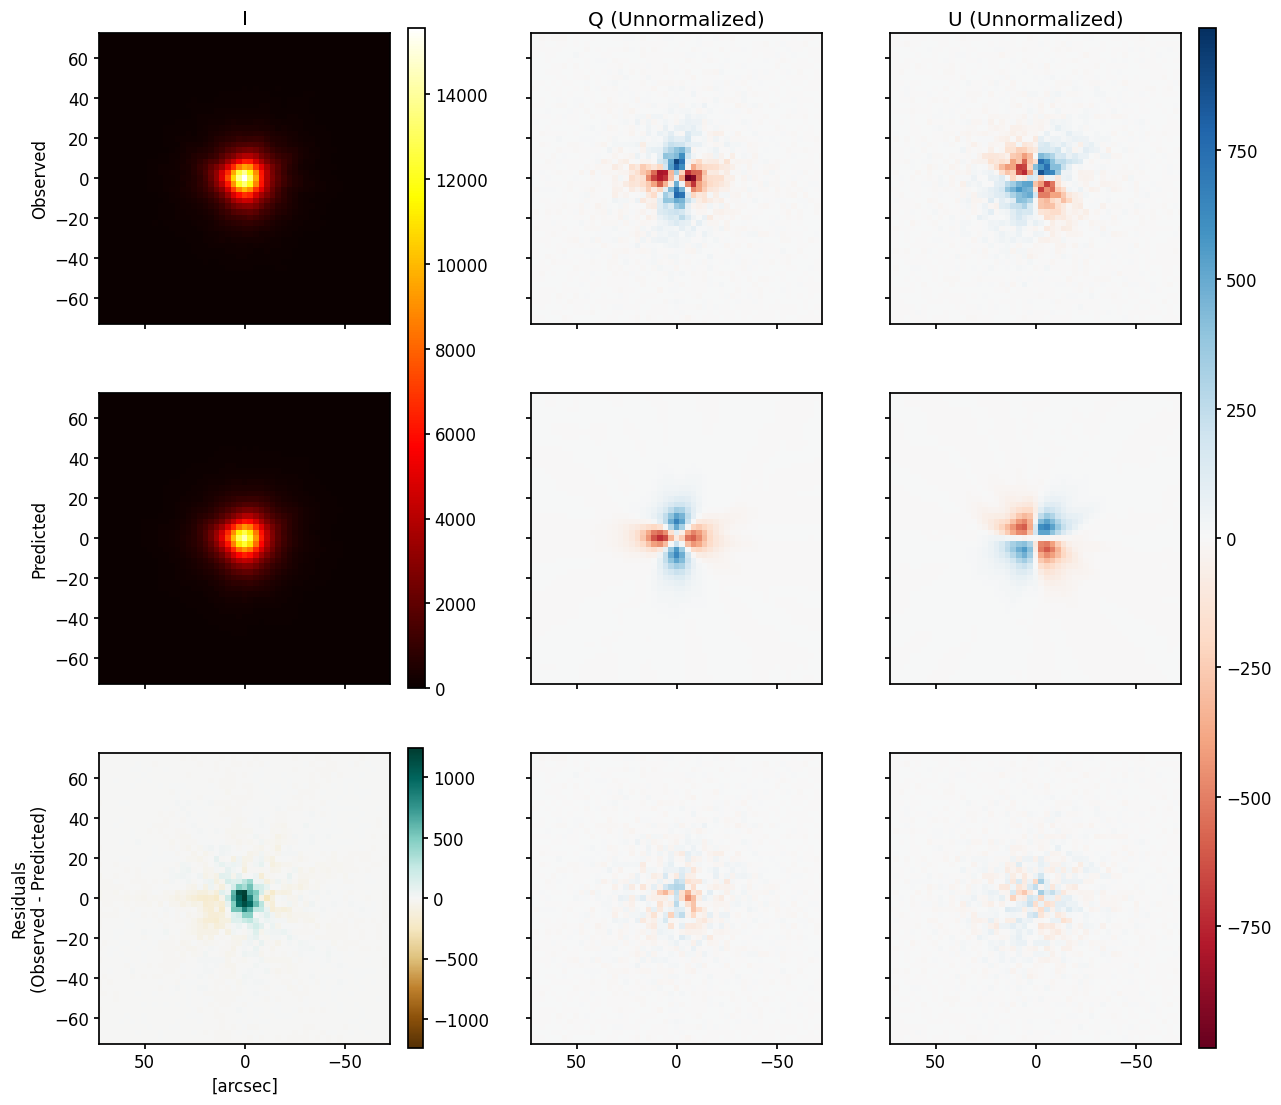

In [7]:
fig, axs = plt.subplots(ncols=3,nrows=3, figsize=(14, 12), sharex=True, sharey=True, gridspec_kw=dict(width_ratios=(1.25,1,1.25)))

vmax = np.max(np.abs([ixpe_data.q, ixpe_data.u, pred_q, pred_u]))
vmax_delta_i = np.max(np.abs(ixpe_data.i - pred_i))
vmaxi = np.max([ixpe_data.i, pred_i])

ci = axs[0,0].pcolormesh(source.pixel_centers, source.pixel_centers, ixpe_data.i, vmin=0, vmax=vmaxi)
axs[0,1].pcolormesh(source.pixel_centers, source.pixel_centers, ixpe_data.q, vmax=vmax, vmin=-vmax, cmap="RdBu")
axs[0,2].pcolormesh(source.pixel_centers, source.pixel_centers, ixpe_data.u, vmax=vmax, vmin=-vmax, cmap="RdBu")

axs[1,0].pcolormesh(source.pixel_centers, source.pixel_centers, pred_i, vmin=0, vmax=vmaxi)
axs[1,1].pcolormesh(source.pixel_centers, source.pixel_centers, pred_q, vmax=vmax, vmin=-vmax, cmap="RdBu")
axs[1,2].pcolormesh(source.pixel_centers, source.pixel_centers, pred_u, vmax=vmax, vmin=-vmax, cmap="RdBu")

cr = axs[2,0].pcolormesh(source.pixel_centers, source.pixel_centers, ixpe_data.i - pred_i, cmap="BrBG", vmax=vmax_delta_i, vmin=-vmax_delta_i)
axs[2,1].pcolormesh(source.pixel_centers, source.pixel_centers, ixpe_data.q - pred_q, vmax=vmax, vmin=-vmax, cmap="RdBu")
cqu=axs[2,2].pcolormesh(source.pixel_centers, source.pixel_centers, ixpe_data.u - pred_u, vmax=vmax, vmin=-vmax, cmap="RdBu")

for ax in axs.reshape(-1):
    ax.set_aspect("equal")
    ax.set_xlim(source.pixel_centers[-1], source.pixel_centers[0])
    ax.set_ylim(source.pixel_centers[0], source.pixel_centers[-1])

axs[0,0].set_ylabel("Observed")
axs[1,0].set_ylabel("Predicted")
axs[2,0].set_ylabel("Residuals\n(Observed - Predicted)")
axs[0,0].set_title("I")
axs[0,1].set_title("Q (Unnormalized)")
axs[0,2].set_title("U (Unnormalized)")
axs[2,0].set_xlabel("[arcsec]")

fig.colorbar(cqu, ax=axs[:,-1], aspect=60)
fig.colorbar(cr, ax=axs[2,0])
fig.colorbar(ci, ax=axs[(0,1), 0], aspect=40);

## Extended source prediction

Let's suppose we know what the extended source's flux image looks like, with very good resolution (e.g. a Chandra observation). Assuming that flux is stored in `data/prediction/pwn-i.fits`, 

In [8]:
source = leakagelib.Source.load_file("data/prediction/pwn-i.fits", False, SOURCE_SIZE, PIXEL_SIZE)

Now we'll give it a model polarization map, and ask what the resulting leakage pattern is.

In [9]:
source.polarize_file("data/prediction/pwn-qu.fits")

The following code plots the polarization patterns.

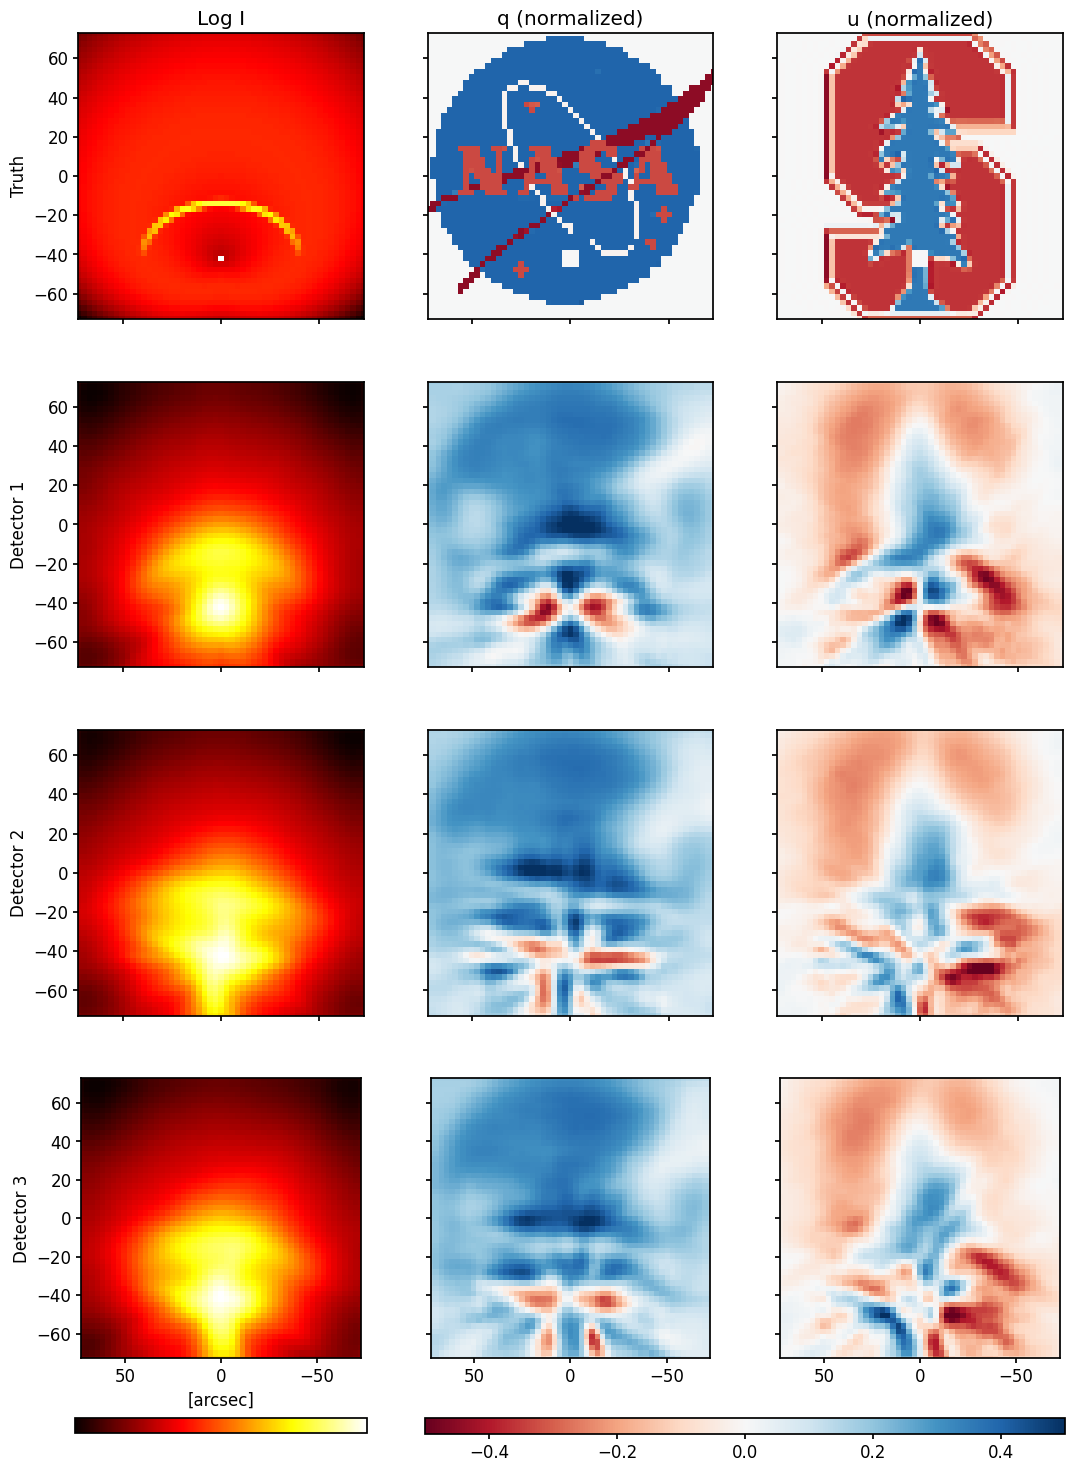

In [10]:
VMAX=0.5
fig, axs = plt.subplots(ncols=3,nrows=4, figsize=(12, 17), sharex=True, sharey=True, gridspec_kw=dict(height_ratios=(1,1,1,1.4)))

axs[0,0].pcolormesh(source.pixel_centers, source.pixel_centers, np.log10(source.source))
axs[0,1].pcolormesh(source.pixel_centers, source.pixel_centers, source.q_map, vmin=-VMAX,vmax=VMAX, cmap="RdBu")
axs[0,2].pcolormesh(source.pixel_centers, source.pixel_centers, source.u_map, vmin=-VMAX,vmax=VMAX, cmap="RdBu")

for det in range(1,4):
    # Load the PSF
    psf = leakagelib.PSF.sky_cal(det, source, det * np.pi / 3 * 2)

    # Get the predicted detection maps for q and u (this time normalized)
    i, q_norm, u_norm = source.compute_leakage(psf, SPECTRUM, normalize=True)

    # Divide by mu, because this is what you would do if you were trying to measure a physical polarization
    q_norm, u_norm = source.divide_by_mu(q_norm, u_norm, SPECTRUM)

    ci = axs[det,0].pcolormesh(source.pixel_centers, source.pixel_centers, np.log10(i))
    axs[det,1].pcolormesh(source.pixel_centers, source.pixel_centers, q_norm, vmax=VMAX, vmin=-VMAX, cmap="RdBu")
    cqu = axs[det,2].pcolormesh(source.pixel_centers, source.pixel_centers, u_norm, vmax=VMAX, vmin=-VMAX, cmap="RdBu")

for ax in axs.reshape(-1):
    ax.set_aspect("equal")
    ax.set_xlim(source.pixel_centers[-1], source.pixel_centers[0])
    ax.set_ylim(source.pixel_centers[0], source.pixel_centers[-1])

axs[0,0].set_ylabel("Truth")
axs[1,0].set_ylabel("Detector 1")
axs[2,0].set_ylabel("Detector 2")
axs[3,0].set_ylabel("Detector 3")
axs[0,0].set_title("Log I")
axs[0,1].set_title("q (normalized)")
axs[0,2].set_title("u (normalized)")
axs[-1,0].set_xlabel("[arcsec]")

fig.colorbar(cqu, ax=axs[-1,(1,2)], orientation="horizontal", aspect=40)
cbari = fig.colorbar(ci, ax=axs[-1,0], orientation="horizontal")
cbari.set_ticks([]);